In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import tensorflow as tf

from environments.buchberger import BinomialBuchbergerEnv, LeadMonomialWrapper
from agents.networks import ParallelMultilayerPerceptron

# Environment

In [2]:
variables = sp.symbols('x y z')
domain = sp.FF(32003)
order = 'grevlex'
degree = 2
size = 5

ENV = LeadMonomialWrapper(BinomialBuchbergerEnv(degree, size, variables, domain=domain, order=order))

# Agents

In [3]:
class RandomAgent:

    def act(self, state):
        return np.random.randint(state.shape[0])

In [4]:
class DegreeAgent:

    def __init__(self, random=False):
        self.random = random

    def act(self, state):
        n = state.shape[2]//2  # number of variables
        degs = np.sum(np.maximum(state[:, :, :n], state[:, :, n:]), axis=2)
        if self.random:
            indices = np.where(degs == np.min(degs))[0]
            return np.random.choice(indices)
        else:
            return np.argmin(degs)

In [5]:
def discounted_rewards(rewards, gamma):
    out = np.empty(len(rewards))
    cumulative_reward = 0
    for i in reversed(range(len(rewards))):
        cumulative_reward = rewards[i] + gamma * cumulative_reward
        out[i] = cumulative_reward
    return list(out)


class PGAgent:
    """A policy gradient agent."""

    def __init__(self, network, learning_rate=0.00025, gamma=0.99):
        self.model = self._buildModel(network, learning_rate)
        self.gamma = gamma

    def act(self, state):
        """Choose an action for the given state."""
        probs = self.model.predict(np.expand_dims(state, axis=0))[0]
        return np.random.choice(len(probs), p=probs)

    def train(self, env, episodes):
        """Train the agent using policy gradients."""
        reward_out = np.zeros(episodes)

        total_states = []
        total_actions = []
        total_rewards = []

        # generate rollouts and discounted rewards
        for i in range(episodes):
            state = env.reset()
            done = False
            states = []
            actions = []
            rewards = []
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                reward_out[i] += reward
                states += [state]
                actions += [action]
                rewards += [reward]
                state = next_state
            rewards = discounted_rewards(rewards, self.gamma)

            total_states += states
            total_actions += actions
            total_rewards += rewards

        # fit to advantage vectors
        for i in range(len(total_states)):
            state = np.expand_dims(total_states[i], axis=0)
            advantage = np.zeros_like(self.model.predict(state))
            advantage[0, total_actions[i]] = total_rewards[i]
            
            self.model.fit(state, advantage, verbose=0)

        return reward_out

    def _buildModel(self, network, learning_rate):
        model = tf.keras.models.clone_model(network)
        loss = 'categorical_crossentropy'
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        model.compile(loss=loss, optimizer=optimizer)
        return model

In [6]:
# set weights on a network so it outputs degree
# use max(a, b) = 0.5 * (relu(a) + relu(b) + relu(a-b) + relu(b-a))

n = len(variables)
scale = 10

filters0 = np.zeros((1, 1, 2*n, 4*n))
filters0[0,0,:,:] = np.vstack((np.hstack((np.eye(n), np.zeros((n,n)), np.eye(n), -np.eye(n))),
                               np.hstack((np.zeros((n,n)), np.eye(n), -np.eye(n), np.eye(n)))))
bias0 = np.zeros(4*n)
filters1 = np.full((1, 1, 4*n, 1), -0.5*scale)
bias1 = np.zeros(1)

network = ParallelMultilayerPerceptron(6, [12])
SetPGAgent = PGAgent(network)
SetPGAgent.model.predict(np.expand_dims(ENV.reset(), axis=0))  # need to run before setting weights
SetPGAgent.model.set_weights([filters0, bias0, filters1, bias1])

# Check on CartPole

In [7]:
import gym

from agents.networks import MultilayerPerceptron

In [8]:
env = gym.make('CartPole-v0')
network = MultilayerPerceptron(4, [128], 2)
agent = PGAgent(network)

In [9]:
epochs = 25
rewards = []
for i in range(epochs):
    r = np.mean(agent.train(env, 100))
    rewards.append(r)
    print("\rEpoch {} - reward: {}".format(i, r), end="")

Epoch 24 - reward: 193.04

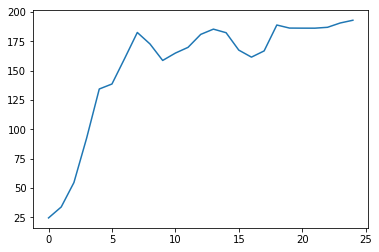

In [10]:
plt.plot(rewards)

# Testing

In [11]:
def test(agent, env, episodes):
    rewards = np.zeros(episodes)
    for i in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.act(state)
            state, reward, done, _ = env.step(action)
            rewards[i] += reward
    return rewards

In [12]:
agent = RandomAgent()
rewards = test(agent, ENV, 100)

np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)

(-35.6, 21.141901522805373, -136.0, -10.0)

In [13]:
agent = DegreeAgent(random=False)
rewards = test(agent, ENV, 100)

np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)

(-21.87, 5.520244559799864, -36.0, -10.0)

In [14]:
agent = DegreeAgent(random=True)
rewards = test(agent, ENV, 100)

np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)

(-21.1, 6.002499479383568, -36.0, -10.0)

In [15]:
agent = SetPGAgent
rewards = test(agent, ENV, 100)

np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)

(-21.33, 6.324642282374554, -36.0, -10.0)

In [16]:
network = ParallelMultilayerPerceptron(6, [12])
agent = PGAgent(network)
epochs = 10000

rewards = []
for i in range(epochs):
    r = np.mean(agent.train(ENV, 100))
    rewards.append(r)
    print("\rEpoch {} - reward: {}".format(i, r), end="")

Epoch 416 - reward: -43.06

KeyboardInterrupt: 

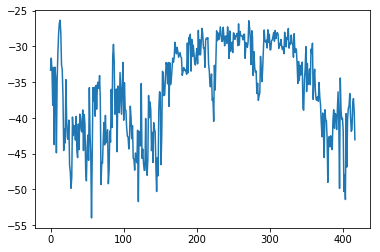

In [17]:
plt.plot(rewards)